In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
%run progress_bar.ipynb

In [3]:
#Read in Data
game_data = pd.read_csv('game_data.csv')
play_info = pd.read_csv('play_information.csv')
play_player_role = pd.read_csv('play_player_role_data.csv')
player_punt = pd.read_csv('player_punt_data.csv')
video_footage_control = pd.read_csv('video_footage-control.csv')
video_footage_injury = pd.read_csv('video_footage-injury.csv')
video_review = pd.read_csv('video_review.csv')

In [4]:
NGS_2016_pre = pd.read_csv('NGS-2016-pre.csv')
NGS_2016_post = pd.read_csv('NGS-2016-post.csv')
# NGS_2017_pre = pd.read_csv('NGS-2017-pre.csv')
# NGS_2017_post = pd.read_csv('NGS-2017-post.csv')

In [5]:
NGS_2016_wk1_6 = pd.read_csv('NGS-2016-reg-wk1-6.csv')
NGS_2016_wk7_12 = pd.read_csv('NGS-2016-reg-wk7-12.csv')
NGS_2016_wk13_17 = pd.read_csv('NGS-2016-reg-wk13-17.csv')

In [6]:
# NGS_2017_wk1_6 = pd.read_csv('NGS-2017-reg-wk1-6.csv')
# NGS_2017_wk7_12 = pd.read_csv('NGS-2017-reg-wk7-12.csv')
# NGS_2017_wk13_17 = pd.read_csv('NGS-2017-reg-wk13-17.csv')

In [7]:
NGS_2016 = pd.concat([NGS_2016_wk1_6, NGS_2016_wk7_12, NGS_2016_wk13_17])

In [ ]:
# NGS_2017 = pd.concat([NGS_2017_wk1_6, NGS_2017_wk7_12, NGS_2017_wk13_17])

In [ ]:
# NGS_df = pd.concat([NGS_2016, NGS_2017])

### Injury Plays EDA

In [16]:
'There are concussion injuries on ' + str(round(len(video_review) / float(len(play_info)) * 100, 2)) + '% of ' + 'punt plays'

'There are concussion injuries on 0.55% of punt plays'

##### It is good for the NFL and players that injuries only occure on less than 1% of punt plays, but it will be hard to do analysis

#### How are players being injured?

In [17]:
trace1 = go.Bar(
        x=video_review.groupby(['Player_Activity_Derived'], as_index=False)['PlayID'].count()['Player_Activity_Derived'],
        y=video_review.groupby(['Player_Activity_Derived'], as_index=False)['PlayID'].count()['PlayID']
    )
trace2 = go.Bar(
        x=video_review.groupby(['Primary_Impact_Type'], as_index=False)['PlayID'].count()['Primary_Impact_Type'],
        y=video_review.groupby(['Primary_Impact_Type'], as_index=False)['PlayID'].count()['PlayID'],
    )
trace3 = go.Bar(
        x=video_review.groupby(['Friendly_Fire'], as_index=False)['PlayID'].count()['Friendly_Fire'],
        y=video_review.groupby(['Friendly_Fire'], as_index=False)['PlayID'].count()['PlayID'],
    )
trace4 = go.Bar(
        x=video_review.groupby(['Primary_Partner_Activity_Derived'], as_index=False)['PlayID'].count()['Primary_Partner_Activity_Derived'],
        y=video_review.groupby(['Primary_Partner_Activity_Derived'], as_index=False)['PlayID'].count()['PlayID'],
    )

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=('Player Activity Derived', 'Primary Impact Type',
                                                          'Friendly Fire', 'Primary Partner Activity Derived'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)

fig['layout'].update(showlegend=False)

py.iplot(fig, filename='make-subplots-multiple-with-titles')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### Quick Conclusions
    - No player activity stands out
    - Helmet to player is primary impact type
    - Friendly fire is only clear 16% of the time
    - No Partner Activity Stands Out

#### Who's getting hurt?

In [18]:
#Categorize player punt roles into the sides of the ball
return_roles = ['PDL1','PDL2','PDL3','PDL4','PDL5','PDL6','PDM','PDR1','PDR2','PDR3','PDR4','PDR5','PDR6'
                ,'PFB','PLL','PLL1','PLL2','PLL3','PLM','PLM1','PLR','PLR1','PLR2','PLR3','PR','VL','VLi'
                ,'VLo','VR','VRi','VRo']

coverage_roles = ['GL','GLi','GLo','GR','GRi','GRo','P','PC','PLG','PLS','PLT','PLW','PPL','PPLi','PPLo'
                 ,'PPR','PPRi','PPRo','PRG','PRT','PRW']

gunner_blockers = ['VL','VLi','VLo','VR','VRi','VRo']

In [19]:
inj_players = video_review.merge(play_player_role, how='inner', on=['Season_Year', 'GameKey', 'PlayID', 'GSISID'])
inj_players.rename(columns={'Role':'inj_role'}, inplace=True)

In [20]:
inj_players['inj_side_of_ball'] = np.where(inj_players.inj_role.isin(return_roles), 'return',
                                          np.where(inj_players.inj_role.isin(coverage_roles), 'coverage', ''))

In [21]:
partner_players = video_review[['Season_Year', 'GameKey', 'PlayID', 'Primary_Partner_GSISID']]
partner_players['Primary_Partner_GSISID'] = partner_players.loc[:,'Primary_Partner_GSISID'] \
                                                .replace('Unclear','0').fillna(0).astype(int)
partner_players = partner_players.merge(play_player_role, how='left', \
                                        left_on=['Season_Year', 'GameKey', 'PlayID', 'Primary_Partner_GSISID'],\
                                       right_on =['Season_Year', 'GameKey', 'PlayID', 'GSISID'])
partner_players = partner_players.drop('GSISID', axis=1)
partner_players.rename(columns={'Role':'partner_role'}, inplace=True)
partner_players['partner_side_of_ball'] = np.where(partner_players.partner_role.isin(return_roles), 'return',
                                          np.where(partner_players.partner_role.isin(coverage_roles), 'coverage', ''))
inj_partner_df = pd.concat([inj_players,partner_players[['partner_role','partner_side_of_ball']]], axis = 1)

In [22]:
inj_partner_df.head()

,Season_Year,GameKey,PlayID,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire,inj_role,inj_side_of_ball,partner_role,partner_side_of_ball
0,2016,5,3129,31057,Tackling,No,Helmet-to-body,32482,Tackled,No,PLW,coverage,PR,return
1,2016,21,2587,29343,Blocked,No,Helmet-to-helmet,31059,Blocking,No,GL,coverage,PLL1,return
2,2016,29,538,31023,Tackling,No,Helmet-to-body,31941,Tackled,No,GR,coverage,PR,return
3,2016,45,1212,33121,Tackling,No,Helmet-to-body,28249,Tackled,No,PRT,coverage,PR,return
4,2016,54,1045,32444,Blocked,No,Helmet-to-body,31756,Blocked,Yes,PRT,coverage,GR,coverage


In [23]:
partner_players.partner_side_of_ball.value_counts()

return      18
coverage    15
             4
Name: partner_side_of_ball, dtype: int64

#### On what types of plays are players getting hurt?

In [24]:
#Create a column in the play_info dataframe to determine the type of play
play_info['outcome'] = np.where(play_info['PlayDescription'].str.contains('fair catch', flags=re.IGNORECASE, regex=True), 'fair_catch',
                        np.where(play_info['PlayDescription'].str.contains('touchback', flags=re.IGNORECASE, regex=True), 'touchback',
                        np.where(play_info['PlayDescription'].str.contains('out of bounds', flags=re.IGNORECASE, regex=True), 'oob',
                        np.where(play_info['PlayDescription'].str.contains('downed', flags=re.IGNORECASE, regex=True), 'downed',
                        np.where(play_info['PlayDescription'].str.contains('blocked', flags=re.IGNORECASE, regex=True), 'blocked',
                        np.where(play_info['PlayDescription'].str.contains('fake|pass', flags=re.IGNORECASE, regex=True), 'fake', 
                        np.where(play_info['PlayDescription'].str.contains('safety', flags=re.IGNORECASE, regex=True), 'safety',
                        np.where(play_info['PlayDescription'].str.contains('[0-9]+ for [-+]?[0-9]+ yards?|for no gain|muffs|touchdown', flags=re.IGNORECASE, regex=True), 'return',         
                        np.where(play_info['PlayDescription'].str.contains('- no play|delay of game|false start, declined|penalty enforced', flags=re.IGNORECASE, regex=True), 'no_play', ' ')))))))))

In [25]:
pi = play_info.merge(video_review[['Season_Year', 'GameKey', 'PlayID','GSISID']], how='left', on =['Season_Year', 'GameKey', 'PlayID'])
pi['injury'] = np.where(pi.GSISID.notnull(), 1, 0).astype(int)
pi.drop('GSISID', axis = 1, inplace=True)
vr = play_info.merge(video_review, how='inner', on =['Season_Year', 'GameKey', 'PlayID'])

In [26]:
vr.outcome.value_counts()

return        32
downed         3
fair_catch     2
Name: outcome, dtype: int64

#### Conclusion: players are getting hurt on returns 

In [27]:
#Is it a higher proportion compared to all plays?

In [28]:
pi_inj_grouped = pi.groupby(['outcome'], as_index=False)['injury'] \
    .agg({'total_plays':'count','injuries':sum}) \
    .sort_values('total_plays', ascending = False) \
    .reset_index(drop=True)

pi_inj_grouped['injury_percentage'] = round(pi_inj_grouped['injuries'] / pi_inj_grouped['total_plays'] * 100, 1).astype(str) + '%'
pi_inj_grouped

,outcome,total_plays,injuries,injury_percentage
0,return,2917,32,1.1%
1,fair_catch,1663,2,0.1%
2,downed,802,3,0.4%
3,oob,696,0,0.0%
4,touchback,407,0,0.0%
5,no_play,139,0,0.0%
6,blocked,26,0,0.0%
7,fake,25,0,0.0%
8,safety,6,0,0.0%


#### Conclusion: over 1% of punt plays with a return have an injury
    - **** This is 10x higher than when a fair catch is called

### Does speed correlate with injury?

In [29]:
injury_ngs = video_review.merge(NGS_2016, how ='inner', left_on=['GSISID','PlayID','GameKey'], right_on=['GSISID','PlayID','GameKey'])

In [248]:
injury_ngs['dis_per_second'] = injury_ngs.dis * 10
injury_ngs['dis_mph'] = injury_ngs.dis_per_second * 2.0455

In [251]:
injury_ngs.groupby('PlayID')['dis_mph'].agg(max)

PlayID
1526    18.000400
1976    17.591300
2341    19.432250
2342    20.864100
2667    21.068649
2902    13.500301
2918     5.727400
3278    18.409500
3468    17.795850
3509    13.909400
3609    19.432250
3663    10.841149
3746    19.432250
Name: dis_mph, dtype: float64

In [256]:
vr_merged.head()

,Season_Year,Season_Type,GameKey,Game_Date,Week,PlayID,Game_Clock,YardLine,Quarter,Play_Type,...,Score_Home_Visiting,PlayDescription,outcome,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire
0,2016,Pre,5,08/11/2016,2,3129,03:44,CHI 31,3,Punt,...,0 - 22,(3:44) (Punt formation) P.O'Donnell punts 58 y...,return,31057,Tackling,No,Helmet-to-body,32482,Tackled,No
1,2016,Pre,21,08/20/2016,3,2587,05:52,TEN 45,3,Punt,...,10 - 13,(5:52) (Punt formation) K.Redfern punts 36 yar...,downed,29343,Blocked,No,Helmet-to-helmet,31059,Blocking,No
2,2016,Pre,29,08/19/2016,3,538,04:46,NYJ 22,1,Punt,...,0 - 0,"(4:46) L.Edwards punts 51 yards to WAS 27, Cen...",return,31023,Tackling,No,Helmet-to-body,31941,Tackled,No
3,2016,Pre,45,08/27/2016,4,1212,08:29,NYG 46,2,Punt,...,0 - 0,"(8:29) B.Wing punts 44 yards to NYJ 10, Center...",return,33121,Tackling,No,Helmet-to-body,28249,Tackled,No
4,2016,Pre,54,09/01/2016,5,1045,09:57,PIT 24,2,Punt,...,6 - 0,"(9:57) J.Berry punts 45 yards to CAR 31, Cente...",return,32444,Blocked,No,Helmet-to-body,31756,Blocked,Yes


In [395]:
import plotly

In [258]:
import plotly.graph_objs as go
from plotly import offline
import plotly.plotly as py
plotly.tools.set_credentials_file(username='mtodisco10', api_key='bCfUmq5FralbymKXY4uX')

In [396]:
def load_layout():
    """
    Returns a dict for a Football themed Plot.ly layout 
    """
    layout = dict(
        title = "Player Activity",
        plot_bgcolor='darkseagreen',
        showlegend=True,
        xaxis=dict(
            autorange=False,
            range=[0, 120],
            showgrid=False,
            zeroline=False,
            showline=True,
            linecolor='black',
            linewidth=1,
            mirror=True,
            ticks='',
            tickmode='array',
            tickvals=[10,20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
            ticktext=['Goal', 10, 20, 30, 40, 50, 40, 30, 20, 10, 'Goal'],
            showticklabels=True
        ),
        yaxis=dict(
            title='',
            autorange=False,
            range=[-3.3,56.3],
            showgrid=False,
            zeroline=False,
            showline=True,
            linecolor='black',
            linewidth=1,
            mirror=True,
            ticks='',
            showticklabels=False
        ),
        shapes=[
            dict(
                type='line',
                layer='below',
                x0=0,
                y0=0,
                x1=120,
                y1=0,
                line=dict(
                    color='white',
                    width=2
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=0,
                y0=53.3,
                x1=120,
                y1=53.3,
                line=dict(
                    color='white',
                    width=2
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=10,
                y0=0,
                x1=10,
                y1=53.3,
                line=dict(
                    color='white',
                    width=10
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=20,
                y0=0,
                x1=20,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=30,
                y0=0,
                x1=30,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=40,
                y0=0,
                x1=40,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=50,
                y0=0,
                x1=50,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=60,
                y0=0,
                x1=60,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=70,
                y0=0,
                x1=70,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=80,
                y0=0,
                x1=80,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=90,
                y0=0,
                x1=90,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=100,
                y0=0,
                x1=100,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=110,
                y0=0,
                x1=110,
                y1=53.3,
                line=dict(
                    color='white',
                    width=10
                )
            )
        ]
    )
    return layout

layout = load_layout()

In [397]:
# Loading and plotting functions

def load_plays_for_game(GameKey):
    """
    Returns a dataframe of play data for a given game (GameKey)
    """
    play_information = pd.read_csv('play_information.csv')
    play_information = play_information[play_information['GameKey'] == GameKey]
    return play_information


def load_game_and_ngs(ngs_file=None, GameKey=None):
    """
    Returns a dataframe of player movements (NGS data) for a given game
    """
    if ngs_file is None:
        print("Specifiy an NGS file.")
        return None
    if GameKey is None:
        print('Specify a GameKey')
        return None
    # Merge play data with NGS data    
    plays = load_plays_for_game(GameKey)
    ngs = pd.read_csv(ngs_file, low_memory=False)
    merged = pd.merge(ngs, plays, how="inner", on=["GameKey", "PlayID", "Season_Year"])
    return merged


def plot_play(game_df, PlayID, player1=None, player2=None, custom_layout=False):
    """
    Plots player movements on the field for a given game, play, and two players
    """
    game_df = game_df[game_df.PlayID==PlayID]
    
    GameKey=str(pd.unique(game_df.GameKey)[0])
    HomeTeam = pd.unique(game_df.Home_Team_Visit_Team)[0].split("-")[0]
    VisitingTeam = pd.unique(game_df.Home_Team_Visit_Team)[0].split("-")[1]
    YardLine = game_df[(game_df.PlayID==PlayID) & (game_df.GSISID==player1)]['YardLine'].iloc[0]
    
    traces=[]   
    if (player1 is not None) & (player2 is not None):
        game_df = game_df[ (game_df['GSISID']==player1) | (game_df['GSISID']==player2)]
        for player in pd.unique(game_df.GSISID):
            player = int(player)
            trace = go.Scatter(
                x = game_df[game_df.GSISID==player].x,
                y = game_df[game_df.GSISID==player].y,
                name='GSISID '+str(player),
                mode='markers'
            )
            traces.append(trace)
    else:
        print("Specify GSISIDs for player1 and player2")
        return None
    
    if custom_layout is not True:
        layout = load_layout()
        layout['title'] =  HomeTeam + \
        ' vs. ' + VisitingTeam + \
        '<br>Possession: ' + \
        YardLine.split(" ")[0] +'@'+YardLine.split(" ")[1]
    data = traces
    fig = dict(data=data, layout=layout)
    play_description = game_df[(game_df.PlayID==PlayID) & (game_df.GSISID==player1)].iloc[0]["PlayDescription"]
    print("\n\n\t",play_description)
    py.iplot(fig,filename='jupyter-table1')
    #offline.iplot(fig)

In [398]:
game280 = load_game_and_ngs('NGS-2016-reg-wk13-17.csv',GameKey=280)

In [399]:
plot_play(game_df=game280, PlayID=2918, player1=32120, player2=32725)



	 (3:36) B.Nortman punts 49 yards to HST 30, Center-C.Tinker, fair catch by W.Fuller.
High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mtodisco10/0 or inside your plot.ly account where it is named 'jupyter-table1'


#### Speed Function

In [263]:
def get_speed(ng_data, playId, gameKey, player, partner):
    ng_data = pd.read_csv(ng_data)
    ng_data['mph'] = convert_to_mph(ng_data['dis'], 20.455)
    player_data = ng_data.loc[(ng_data.GameKey == gameKey) & (ng_data.PlayID == playId) 
                               & (ng_data.GSISID == player)].sort_values('Time')
    partner_data = ng_data.loc[(ng_data.GameKey == gameKey) & (ng_data.PlayID == playId) 
                              & (ng_data.GSISID == partner)].sort_values('Time')
    player_grouped = player_data.groupby(['GameKey','PlayID','GSISID'], 
                               as_index = False)['mph'].agg({'max_mph': max,
                                                             'avg_mph': np.mean
                                                            })
    player_grouped['involvement'] = 'player_injured'
    partner_grouped = partner_data.groupby(['GameKey','PlayID','GSISID'], 
                               as_index = False)['mph'].agg({'max_mph': max,
                                                             'avg_mph': np.mean
                                                            })
    partner_grouped['involvement'] = 'primary_partner'
    return pd.concat([player_grouped, partner_grouped], axis = 0)[['involvement',
                                                                   'max_mph',
                                                                   'avg_mph']].reset_index(drop=True)

def convert_to_mph(dis_vector, converter):
    mph_vector = dis_vector * converter
    return mph_vector

get_speed('NGS-2016-pre.csv', 3129, 5, 31057, 32482)

#### Calculate hang time of punts

In [30]:
def get_hang_time(ngs_df, start_event='punt', *stop_events):
    punt_event = ngs_df.loc[ngs_df.Event==start_event] \
        .groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
    punt_event.rename(columns = {'Time':'punt_time'}, inplace=True)
    punt_event['punt_time'] = pd.to_datetime(punt_event['punt_time'],\
                                             format='%Y-%m-%d %H:%M:%S.%f')
    
    receiving_event = ngs_df.loc[ngs_df.Event.isin(stop_events)] \
        .groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
    receiving_event.rename(columns = {'Time':'receiving_time'}, inplace=True)
    receiving_event['receiving_time'] = pd.to_datetime(receiving_event['receiving_time'],\
                                             format='%Y-%m-%d %H:%M:%S.%f')
    
    punt_df = punt_event.merge(receiving_event, how='inner', on = ['Season_Year','GameKey','PlayID']) \
                .reset_index(drop=True)
    
    punt_df['hang_time'] = (punt_df['receiving_time'] - punt_df['punt_time']).dt.total_seconds()
    
    return punt_df

In [31]:
punt_df = get_hang_time(NGS_2016, 'punt', 'punt_received', 'fair_catch')

In [32]:
data = [go.Histogram(x=punt_df.hang_time)]

py.iplot(data, filename='basic histogram')

In [33]:
round(punt_df['hang_time'].mean(), 1)

4.5

In [34]:
round(punt_df['hang_time'].median(), 1)

4.5

In [35]:
str(round(len(punt_df.loc[punt_df.hang_time < 5.5]) / len(punt_df) * 100, 1)) + '% of hang times are less than 5 1/2 seconds'

'97.1% of hang times are less than 5 1/2 seconds'

### Calculate distance between returner and closest coverage man

In [36]:
play_info_2016_pre = pi.loc[pi['Season_Year'] == 2016]

In [37]:
#Create a function to calculate the space between the returner and the closest coverage player for every second between the punt and the catch
def coverage_returner_space(play_df, ngs_df):
    cov_ret_lst = []
    play_df = play_df.loc[(play_df.outcome == 'fair_catch') | (play_df.outcome == 'return')].reset_index(drop=True)
    for i in log_progress(range(0, len(play_df)), every=25):
        season_key = play_df['Season_Year'][i]
        game_key = play_df['GameKey'][i]
        play_id = play_df['PlayID'][i]
        outcome = play_df['outcome'][i]
        injury = play_df['injury'][i]
        if game_key in ngs_df.GameKey and play_id in ngs_df.PlayID:
            filtered_play = ngs_df.loc[(ngs_df.GameKey == game_key) \
                                       & (ngs_df.PlayID == play_id)].sort_values('Time').reset_index(drop=True)
            filtered_play = filtered_play.merge(play_player_role, \
                                                how='inner', on = ['Season_Year','GameKey','PlayID','GSISID'])
            if len(filtered_play) > 0:
                filtered_play['Time'] = pd.to_datetime(filtered_play['Time'], \
                                                       format='%Y-%m-%d %H:%M:%S.%f')
                punt_event_time = filtered_play.loc[filtered_play.Event == 'punt'].Time.min()
                receiving_event_time = filtered_play.loc[(filtered_play.Event == 'punt_received') | \
                                                         (filtered_play.Event == 'fair_catch')].Time.min()
                gunner_blocker_count = len(filtered_play.loc[filtered_play['Role'].isin(gunner_blockers)]['Role'].unique())
                filtered_play = filtered_play.loc[(filtered_play.Time >= punt_event_time) & \
                                                  (filtered_play.Time <= receiving_event_time)]
                coverage_df = filtered_play.loc[filtered_play['Role'].isin(coverage_roles)].sort_values('Time')
                coverage_df.rename(columns={'x':'cov_x', 
                                          'y': 'cov_y',
                                          'GSISID': 'cov_GSISID',
                                          'dis': 'cov_dis',
                                          'o': 'cov_o',
                                          'dir': 'cov_dir',
                                          'Role': 'cov_Role'
                                         }, inplace=True)
                
                returner_df = filtered_play.loc[filtered_play['Role'] == 'PR'].sort_values('Time')
                returner_df.rename(columns={'x':'ret_x', 
                                          'y': 'ret_y',
                                          'GSISID': 'ret_GSISID',
                                          'dis': 'ret_dis',
                                          'o': 'ret_o',
                                          'dir': 'ret_dir',
                                          'Role': 'ret_Role'
                                         }, inplace=True)
                returner_df = returner_df.drop('Event', axis = 1)
                
                cov_ret_df = coverage_df.merge(returner_df, how ='inner', on = ['Season_Year','GameKey','PlayID','Time'])
                cov_ret_df['dis_from_ret'] = ((cov_ret_df['cov_x'] -  cov_ret_df['ret_x']) ** 2 \
                                           + (cov_ret_df['cov_y'] -  cov_ret_df['ret_y']) ** 2).apply(np.sqrt)
                cov_ret_df['time_since_punt'] = cov_ret_df['Time'] - punt_event_time
                times_to_capture = [punt_event_time + pd.Timedelta(seconds=i) for i in range(1, 7)]
                cov_ret_df = cov_ret_df.loc[cov_ret_df['Time'].isin(times_to_capture)]
                cov_ret_df['gunner_blockers'] = gunner_blocker_count
                cov_ret_df['outcome'] = outcome
                cov_ret_df['injury'] = injury
                cov_ret_df['cov_speed'] = convert_to_mph(cov_ret_df.cov_dis, 20.455)
                cov_ret_df['ret_speed'] = convert_to_mph(cov_ret_df.ret_dis, 20.455)
                if len(cov_ret_df) > 0:
                    cov_ret_lst.append(cov_ret_df)
                    
    cov_ret_df = pd.concat(cov_ret_lst).reset_index(drop=True)          
    return cov_ret_df

In [38]:
def convert_to_mph(dis_vector, converter):
    mph_vector = dis_vector * converter
    return mph_vector

In [ ]:
cov_ret_df = coverage_returner_space(pi, NGS_2016)

In [390]:
cov_ret_df.gunner_blockers.value_counts(normalize=True)

4    0.593950
2    0.204015
3    0.195957
1    0.004052
0    0.002026
Name: gunner_blockers, dtype: float64

In [393]:
#Speed vs Number of Gunner Blockers at each second.

pd.pivot_table(cov_ret_df.loc[(cov_ret_df.cov_Role == 'GR') | (cov_ret_df.cov_Role == 'GL')], 
               index=['gunner_blockers'], values='cov_speed',
               columns=['time_since_punt'], aggfunc=[np.mean, np.median])

mean                                              \
time_since_punt   00:00:01   00:00:02   00:00:03   00:00:04   00:00:05   
gunner_blockers                                                          
0                10.022950  12.375275  14.829875  12.375275        NaN   
1                17.693575  19.739074  17.898125  14.881013        NaN   
2                17.321666  18.089245  17.187365  14.836770  13.132110   
3                16.217893  17.059470  17.141752  16.327689  14.034919   
4                14.342336  15.559607  16.334269  16.438777  14.267362   

                               median                                   \
time_since_punt   00:00:06   00:00:01   00:00:02   00:00:03   00:00:04   
gunner_blockers                                                          
0                      NaN  10.022950  12.375275  14.829875  12.375275   
1                      NaN  18.204950  19.739074  17.284475  16.568550   
2                18.716325  17.591300  18.818600  17.898125  15.954899   
3                10.585462  17.182199  18.511775  18.204950  16.977650   
4                12.022995  15.136700  16.364000  17.182199  16.568550   

                                      
time_since_punt  00:00:05   00:00:06  
gunner_blockers                       
0                     NaN        NaN  
1                     NaN        NaN  
2                13.09120  18.716325  
3                15.34125  10.636600  
4                15.34125  12.477550

In [392]:
# Average distance for all player at the X second mark.  Return vs Fair Catch
pd.pivot_table(cov_ret_df, values='dis_from_ret', index=['time_since_punt'], columns=['outcome'], aggfunc=[np.mean, np.median])

mean                median           
outcome         fair_catch     return fair_catch     return
time_since_punt                                            
00:00:01         43.745141  48.787006  44.745955  48.702027
00:00:02         38.552676  44.080256  39.303885  43.690657
00:00:03         31.307944  37.742900  31.293622  37.075601
00:00:04         24.117084  31.914132  23.126849  30.949322
00:00:05         18.925329  28.189252  17.190653  26.311259
00:00:06         20.045922  22.437433  17.030813  19.381877

In [394]:
pd.pivot_table(cov_ret_df, values='dis_from_ret', index=['time_since_punt'], columns=['outcome','gunner_blockers'], aggfunc=np.mean)

outcome         fair_catch                                      return  \
gunner_blockers          1          2          3          4          0   
time_since_punt                                                          
00:00:01         39.970724  41.291033  43.798463  46.537340  46.835844   
00:00:02         35.633095  36.049210  39.118778  41.073572  43.787933   
00:00:03         30.055284  29.334707  32.337813  32.909893  37.573491   
00:00:04         24.987765  23.248568  25.213161  24.396625  31.676056   
00:00:05               NaN  18.706759  17.912799  19.370232        NaN   
00:00:06               NaN        NaN        NaN  20.045922        NaN   

outcome                                                      
gunner_blockers          1          2          3          4  
time_since_punt                                              
00:00:01         47.490862  47.793062  49.603730  48.765326  
00:00:02         42.287920  43.377784  44.828234  44.014931  
00:00:03         35.237645  37.305237  38.550498  37.604682  
00:00:04         26.754987  31.488348  32.758687  31.782361  
00:00:05               NaN  32.515076  28.533237  27.434877  
00:00:06               NaN  20.728033  19.263292  23.588531

In [289]:
#### At each second of each play... Who is the closest to the returner?  How far away are they?  Return vs Fair Catch

In [288]:
min_dist_from_ret = cov_ret_df.groupby(['Season_Year', 'GameKey','PlayID','time_since_punt'], as_index = False)['dis_from_ret'].min()

In [290]:
min_dist_from_ret.head()

,Season_Year,GameKey,PlayID,time_since_punt,dis_from_ret
0,2016,3,455,00:00:01,39.068560
1,2016,3,455,00:00:02,31.370344
2,2016,3,455,00:00:03,21.645880
3,2016,3,455,00:00:04,11.321985
4,2016,3,1542,00:00:01,38.607731


In [291]:
closest_df = cov_ret_df.merge(min_dist_from_ret.drop('time_since_punt', axis = 1), how = 'inner', on=['Season_Year', 'GameKey', 'PlayID', 'dis_from_ret'])

In [292]:
#closest_df.groupby(['time_since_punt','cov_Role'], as_index=False)['dis_from_ret'].agg({'# of times closest': 'count','avg distance':np.mean}).sort_values('# of times closest', ascending =False)

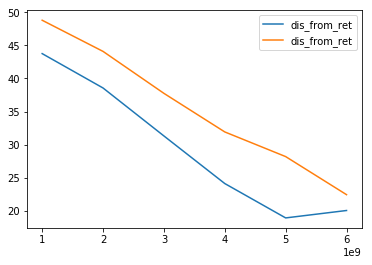

In [295]:
plt.plot(df_grouped.loc[df_grouped['outcome']=='fair_catch']['time_since_punt'], df_grouped.loc[df_grouped['outcome']=='fair_catch']['dis_from_ret'])
plt.plot(df_grouped.loc[df_grouped['outcome']=='return']['time_since_punt'], df_grouped.loc[df_grouped['outcome']=='return']['dis_from_ret'])
plt.legend()

In [296]:
pos_grouped_df = cov_ret_df.groupby(['cov_Role','time_since_punt', 'outcome'], as_index=False)['dis_from_ret'].mean()

In [297]:
trace1 = go.Bar(
        x=pos_grouped_df.loc[pos_grouped_df.outcome == 'fair_catch']['cov_Role'],
        y=pos_grouped_df.loc[pos_grouped_df.outcome == 'fair_catch']['dis_from_ret'],
        name='fair catch'
    )

trace2 = go.Bar(
        x=pos_grouped_df.loc[pos_grouped_df.outcome == 'return']['cov_Role'],
        y=pos_grouped_df.loc[pos_grouped_df.outcome == 'return']['dis_from_ret'],
        name='return'
    )

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    xaxis=dict(title='Position'),
    yaxis= dict(title='Avg Distance From Returner (Yds)')
)

fig=go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

#### Punts Received inside the 20

In [ ]:
play_info.head()

In [26]:
NGS_2016.loc[(NGS_2016.Event == 'punt_received') & (NGS_2016.Season_Year == 2016) \
            & (NGS_2016.GameKey == 60) & (NGS_2016.PlayID == 905)].sort_values('x')

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event


In [22]:
play_player_role.loc[(play_player_role.GSISID == 28091.0) & (play_player_role.PlayID == 2342)]

,Season_Year,GameKey,PlayID,GSISID,Role
20654,2016,144,2342,28091,PR


In [23]:
NGS_2016.x.max()

130.47999572753906

In [24]:
NGS_2016.x.min()

-9.5600004196166992

In [27]:
len(NGS_2016.loc[((NGS_2016.x > 90) | (NGS_2016.x <30)) & (NGS_2016.Event == 'punt_received')].PlayID.unique())

653

In [28]:
len(NGS_2016.loc[NGS_2016.Event == 'punt_received'].PlayID.unique())

917

In [29]:
653 / 917

0.7121046892039259